<a href="https://colab.research.google.com/github/dguevaraapaza/H1N1-Seasonal-Flu-Vaccine/blob/main/H1N1_and_seasonal_flu_vaccines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vaccination Prediction


> **Goal:** Predict how likely individuals are to receive their H1N1 and seasonal flu vaccines. In specific, the target is to predict two probabilities: one for h1n1_vaccine and one for seasonal_vaccine.

**This is a multi-label classification problem.**

In [ ]:
## Installing the required packages
# !pip install scikit-multilearn

# Libraries for Problem Transformation
# from skmultilearn.problem_transform import BinaryRelevance
# from skmultilearn.problem_transform import ClassifierChain
# from skmultilearn.problem_transform import LabelPowerset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA

# Libraries for model training
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split , GridSearchCV , cross_val_score

# Libraries for algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# Libraries for testing
from sklearn.metrics import accuracy_score , classification_report

# Removing warnings
import warnings
warnings.filterwarnings('ignore')

#Check missing values
import missingno as msno

# Storing plots
%matplotlib inline

## **1. Preprocessing**

In [ ]:
# Load data
!wget -q -O H1N1_Flu_Vaccines.csv https://raw.githubusercontent.com/dguevaraapaza/H1N1-Seasonal-Flu-Vaccine/refs/heads/main/data/H1N1_Flu_Vaccines.csv
vac = pd.read_csv('H1N1_Flu_Vaccines.csv', index_col='respondent_id', delimiter=',')

In [ ]:
# Records that have multiple empty values

# Calculate the number of missing values per row
missing_counts = vac.isnull().sum(axis=1)

# Find rows with more than a certain threshold of missing values
threshold = 5  #5 missing values
rows_with_multiple_missing = vac[missing_counts > threshold]

# Display the rows with multiple missing values
rows_with_multiple_missing

# Alternatively, to just get the indices of these rows
indices_with_multiple_missing = rows_with_multiple_missing.index.tolist()
print(len(indices_with_multiple_missing))
#print(indices_with_multiple_missing)

# Dropping the values in indices_with_multiple_missing
vac = vac.drop(indices_with_multiple_missing)

1609


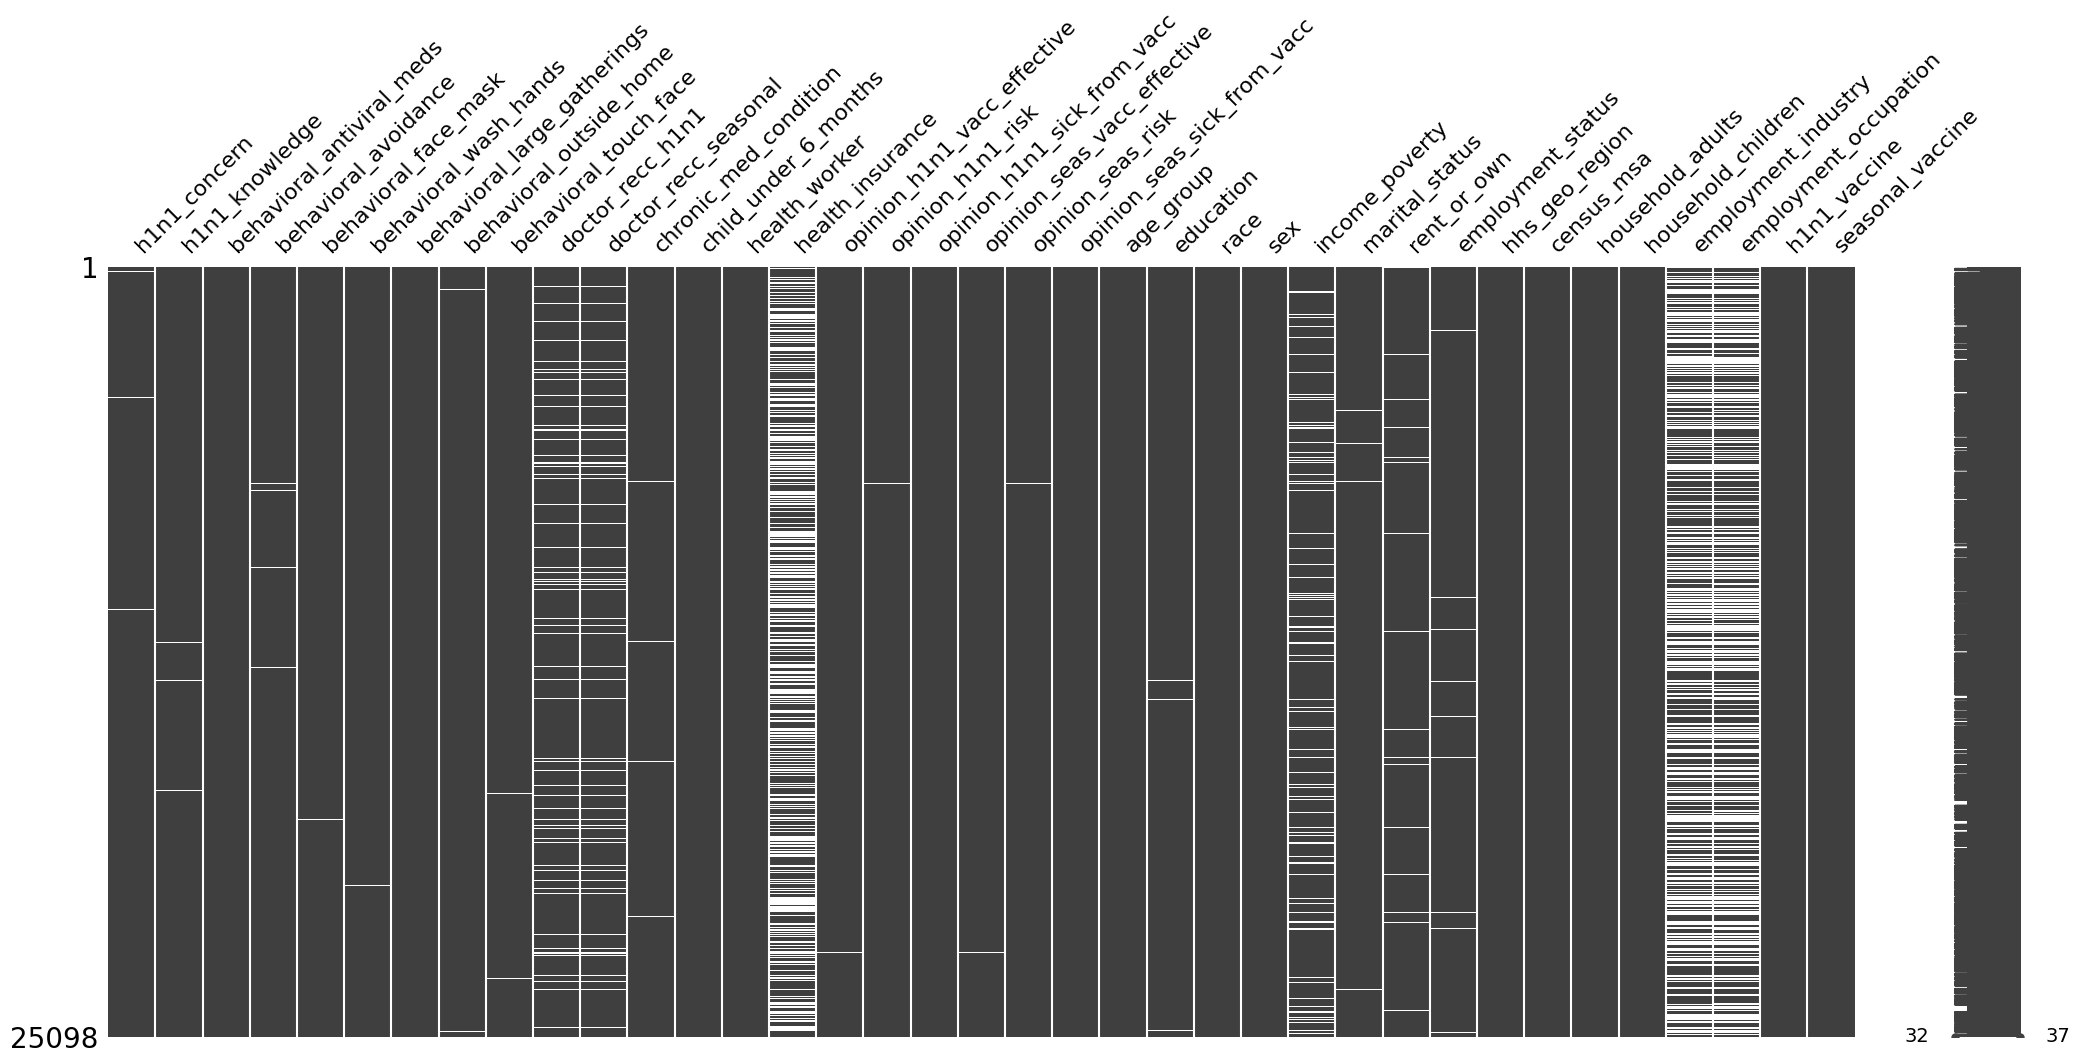

In [ ]:
import missingno as msno
msno.matrix(vac)
plt.show()

In [ ]:
# prompt: prepare a table with the amount of is.na values true and false from all the columns

import pandas as pd

# Assuming 'vac' DataFrame is already loaded as in the provided code.

na_counts = pd.DataFrame()

for col in vac.columns:
    true_count = vac[col].isna().sum()
    false_count = len(vac) - true_count  # Calculate false counts
    na_counts = pd.concat([na_counts, pd.DataFrame({'Column': [col], 'Empty': [true_count], 'Non-Empty': [false_count]})], ignore_index=True)

na_counts = na_counts.sort_values(by='Empty', ascending=False)
na_counts.head(10)

,Column,Empty,Non-Empty
34,employment_occupation,11868,13230
33,employment_industry,11731,13367
14,health_insurance,10739,14359
25,income_poverty,2892,22206
9,doctor_recc_h1n1,1709,23389
10,doctor_recc_seasonal,1709,23389
27,rent_or_own,651,24447
11,chronic_med_condition,198,24900
3,behavioral_avoidance,167,24931
22,education,126,24972


In [ ]:
# Datatype features
vac.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25098 entries, 0 to 26706
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 25044 non-null  float64
 1   h1n1_knowledge               25004 non-null  float64
 2   behavioral_antiviral_meds    25045 non-null  float64
 3   behavioral_avoidance         24931 non-null  float64
 4   behavioral_face_mask         25086 non-null  float64
 5   behavioral_wash_hands        25069 non-null  float64
 6   behavioral_large_gatherings  25029 non-null  float64
 7   behavioral_outside_home      25034 non-null  float64
 8   behavioral_touch_face        25000 non-null  float64
 9   doctor_recc_h1n1             23389 non-null  float64
 10  doctor_recc_seasonal         23389 non-null  float64
 11  chronic_med_condition        24900 non-null  float64
 12  child_under_6_months         25097 non-null  float64
 13  health_worker        

In [ ]:
# check the data types
# for i in vac.columns:
#   print(f'***********************')
#   print(i)
#   print(f'***********************')
#   print(vac[i].value_counts())
#   print(f'-----------------------')
#   print(vac[i].isna().value_counts())
#   print(f'-----------------------')

In [ ]:
# review
categorical = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective',
               'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
               'opinion_seas_vacc_effective', 'opinion_seas_risk',
               'opinion_seas_sick_from_vacc', 'age_group', 'education', 'race',
               'sex', 'marital_status', 'rent_or_own',
               'employment_status', 'household_adults', 'household_children']

binary = ['behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask',
          'behavioral_wash_hands', 'behavioral_large_gatherings',
          'behavioral_outside_home', 'behavioral_touch_face',
          'doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition',
          'child_under_6_months', 'chronic_med_condition', 'health_worker']

# variables to be removed
worst = ['income_poverty', 'hhs_geo_region', 'census_msa', 'employment_industry',
        'employment_occupation', 'health_insurance']

# DATA PRE-PROCESSING

In [ ]:
# Prepare datasets
predictors = ['h1n1_vaccine', 'seasonal_vaccine'] # predictor variables
features = vac[predictors] # (26707, 2)
labels = vac.drop(predictors, axis=1) # (26707, 35)

## Filling the missing values

In [ ]:
# For float fill missing values with the mean

features = features.fillna(features.mean())
features = round(features)

# For string fill missing value with 'No Category'

features = features.fillna('No Category')

In [ ]:
features.isnull().sum()

## Encoding the object

In [ ]:
enc = LabelEncoder()

In [ ]:
features.age_group = enc.fit_transform(features.age_group)
features.education = enc.fit_transform(features.education)
features.race = enc.fit_transform(features.race)
features.sex = enc.fit_transform(features.sex)
features.income_poverty = enc.fit_transform(features.income_poverty)
features.marital_status = enc.fit_transform(features.marital_status)
features.rent_or_own = enc.fit_transform(features.rent_or_own)
features.employment_status = enc.fit_transform(features.employment_status)
features.hhs_geo_region = enc.fit_transform(features.hhs_geo_region)
features.census_msa = enc.fit_transform(features.census_msa)
features.employment_industry = enc.fit_transform(features.employment_industry)
features.employment_occupation = enc.fit_transform(features.employment_occupation)

In [ ]:
features.info()

## Checking the dataset

In [ ]:
features.head(10)

# EXPLORATORY DATA ANALYSIS

## Checking the statistical information

In [ ]:
features.describe()

## Finding the outliers in dataset

In [ ]:
# Function to find the outliers

def findoutliers(column):
    outliers=[]
    Q1=column.quantile(.25)
    Q3=column.quantile(.75)
    IQR=Q3-Q1
    lower_limit=Q1-(1.5*IQR)
    upper_limit=Q3+(1.5*IQR)
    for out1 in column:
        if out1>upper_limit or out1 <lower_limit:
            outliers.append(out1)

    return np.array(outliers)

In [ ]:
print(len(findoutliers(features.household_adults)))
print(len(findoutliers(features.household_children)))

In [ ]:
findoutliers(features.household_adults)

In [ ]:
findoutliers(features.household_children)

In [ ]:
# Visualising the outliers
sns.boxplot(features.household_adults)

In [ ]:
sns.boxplot(features.household_children)

#### There are outliers in the dataset but we are not removing them as some algorithms are not sensitive to outliers

# Visualising numerical data

In [ ]:
sns.displot(features.household_adults)

#### Number of other adults in household is mostly 1.

In [ ]:
sns.displot(features.household_children)

#### Number of children in household is mostly 0.

## Visualising categorical data

In [ ]:
features.h1n1_concern.value_counts()

In [ ]:
sns.factorplot('h1n1_concern', data = features, kind = "count")

#### Most of the people are somewhat concerned about h1n1 vaccine.

In [ ]:
features.h1n1_knowledge.value_counts()

In [ ]:
sns.factorplot('h1n1_knowledge', data = features, kind = "count")

#### Almost 90% of people have little or lots of knowledge about h1n1 vaccine.

In [ ]:
features.behavioral_antiviral_meds.value_counts()

In [ ]:
sns.factorplot('behavioral_antiviral_meds', data = features, kind = "count")

#### Almost non of the people took antiviral medications.

In [ ]:
features.behavioral_avoidance.value_counts()

In [ ]:
sns.factorplot('behavioral_avoidance', data = features, kind = "count")

#### 70% of people have avoided contact with people with symptoms.

In [ ]:
features.behavioral_face_mask.value_counts()

In [ ]:
sns.factorplot('behavioral_face_mask', data = features, kind = "count")

#### Very few people have bought a face mask.

In [ ]:
features.behavioral_wash_hands.value_counts()

In [ ]:
sns.factorplot('behavioral_wash_hands', data = features, kind = "count")

#### 80% of people have frequently washed their hands.

In [ ]:
features.behavioral_large_gatherings.value_counts()

In [ ]:
sns.factorplot('behavioral_large_gatherings', data = features, kind = "count")

#### Few people have reduced time at large gatherings.

In [ ]:
features.behavioral_outside_home.value_counts()

In [ ]:
sns.factorplot('behavioral_outside_home', data = features, kind = "count")

#### Only few people have reduced contact with people outside their household.

In [ ]:
features.behavioral_touch_face.value_counts()

In [ ]:
sns.factorplot('behavioral_touch_face', data = features, kind = "count")

#### 70% of people have avoided touching eyes, nose, or mouth.

In [ ]:
features.doctor_recc_h1n1.value_counts()

In [ ]:
sns.factorplot('doctor_recc_h1n1', data = features, kind = "count")

#### Doctors recommended the h1n1 vaccine to only 20% of people.

In [ ]:
features.doctor_recc_seasonal.value_counts()

In [ ]:
sns.factorplot('doctor_recc_seasonal', data = features, kind = "count")

#### Doctors recommended seasonal vaccine to only 30% of people.

In [ ]:
features.chronic_med_condition .value_counts()

In [ ]:
sns.factorplot('chronic_med_condition', data = features, kind = "count")

#### Only less than 30% of people have chronic medical conditions.

In [ ]:
features.child_under_6_months.value_counts()

In [ ]:
sns.factorplot('child_under_6_months', data = features, kind = "count")

#### Very few people had close contact with child under 6 months.

In [ ]:
features.health_worker.value_counts()

In [ ]:
sns.factorplot('health_worker', data = features, kind = "count")

#### Very few people work in healthcare.

In [ ]:
features.health_insurance.value_counts()

In [ ]:
sns.factorplot('health_insurance', data = features, kind = "count")

#### Almost everyone has health insurance.

In [ ]:
features.opinion_h1n1_vacc_effective.value_counts()

In [ ]:
sns.factorplot('opinion_h1n1_vacc_effective', data = features, kind = "count")

#### Most of the people think h1n1 is somewhat effective.

In [ ]:
features.opinion_h1n1_risk.value_counts()

In [ ]:
sns.factorplot('opinion_h1n1_risk', data = features, kind = "count")

#### Most people believe the h1n1 vaccine has somewhat low or very low risk.

In [ ]:
features.opinion_h1n1_sick_from_vacc.value_counts()

In [ ]:
sns.factorplot('opinion_h1n1_sick_from_vacc', data = features, kind = "count")

#### Most people are not at all worried or not very worried of getting sick from h1n1 vaccine.

In [ ]:
features.opinion_seas_vacc_effective.value_counts()

In [ ]:
sns.factorplot('opinion_seas_vacc_effective', data = features, kind = "count")

#### Most people think seasonal vaccine is somewhat or very effective.

In [ ]:
features.opinion_seas_risk.value_counts()

In [ ]:
sns.factorplot('opinion_seas_risk', data = features, kind = "count")

#### Majority of people think the riske of seasonal vaccine are somewhat low.

In [ ]:
features.opinion_seas_sick_from_vacc.value_counts()

In [ ]:
sns.factorplot('opinion_seas_sick_from_vacc', data = features, kind = "count")

#### Majority of people are not at all worried of getting sick from seasonal vaccine.

## Visualising labels

In [ ]:
sns.factorplot('h1n1_vaccine', data = labels, kind = "count")

In [ ]:
sns.factorplot('seasonal_vaccine', data = labels, kind = "count")

# FEATURE SCALING

## Using Min Max scaler

In [ ]:
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

In [ ]:
features = pd.DataFrame(features)
col_name = ['respondent_id','h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation']
features.columns = col_name

# FEATURE SELECTION

## Independent and target variables

In [ ]:
X = features
y = labels

## Applying SelectKBest class

In [ ]:
bestfeatures = SelectKBest(score_func=chi2, k=30)

In [ ]:
fit = bestfeatures.fit(X,y)

In [ ]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']

print(featureScores.nlargest(25,'Score'))

In [ ]:
features_kbest = features.iloc[:,[9,10,19,16,13,11,21,18,15,34,0,33,32,8,12,1,24,5,26,17,6,3,7,2,4]]

## Feature importance using ExtraTrees Classifier

In [ ]:
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_)
plt.figure(figsize=(10,10))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.show()

In [ ]:
features_tree = features.loc[:,['opinion_seas_risk','doctor_recc_seasonal','opinion_seas_vacc_effective',
                                 'doctor_recc_h1n1','age_group','opinion_h1n1_risk','hhs_geo_region',
                                 'opinion_h1n1_vacc_effective','h1n1_concern','opinion_seas_sick_from_vacc',
                                 'opinion_h1n1_sick_from_vacc','census_msa','education','income_poverty',
                                 'h1n1_knowledge','household_adults','employment_occupation',
                                 'employment_industry','household_children','sex','race','marital_status',
                                 'rent_or_own','behavioral_outside_home','behavioral_large_gatherings']]

## Correlation Matrix using Heatmap

In [ ]:
features.corrwith(labels.h1n1_vaccine)

In [ ]:
features.corrwith(labels.seasonal_vaccine)

In [ ]:
#get correlations of each features in dataset
corrmat = features.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(features[top_corr_features].corr(),annot=True,cmap="Blues")

In [ ]:
features.drop(['opinion_seas_sick_from_vacc','hhs_geo_region','census_msa',
               'household_adults','household_children','behavioral_antiviral_meds',
               'education'], axis = 1, inplace = True)

# MODEL

## Defining independent and dependent variables

In [ ]:
X = features
y = labels

In [ ]:
X

In [ ]:
y

## Splitting the data into training and testing data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=23)

## Using Binary Relevance - Naive Bayes

In [ ]:
# Gaussian Naive Bayes

# Initializing

model_BR_GNB = BinaryRelevance(GaussianNB())

# Training

model_BR_GNB.fit(x_train,y_train)

# Predicting

y_pred_BR_GNB = model_BR_GNB.predict(x_test)

# Testing

BR_GNB = accuracy_score(y_test,y_pred_BR_GNB)
BR_GNB

## Using Binary Relevance - Decision Tree

In [ ]:
# Initializing

model_BR_DT = BinaryRelevance(DecisionTreeClassifier())

# Training

model_BR_DT.fit(x_train,y_train)

# Predicting

y_pred_BR_DT = model_BR_DT.predict(x_test)

# Testing

BR_DT = accuracy_score(y_test,y_pred_BR_DT)
BR_DT

## Using Binary Relevance - Logistic Regression

In [ ]:
# Initializing

model_BR_LR = BinaryRelevance(LogisticRegression())

# Training

model_BR_LR.fit(x_train,y_train)

# Predicting

y_pred_BR_LR = model_BR_LR.predict(x_test)

# Testing

BR_LR = accuracy_score(y_test,y_pred_BR_LR)
BR_LR

## Using Classifier Chains - Naive Bayes

In [ ]:
# Gaussian Naive Bayes

# Initializing

model_CC_GNB = ClassifierChain(GaussianNB())

# Training

model_CC_GNB.fit(x_train,y_train)

# Predicting

y_pred_CC_GNB = model_CC_GNB.predict(x_test)

# Testing

CC_GNB = accuracy_score(y_test,y_pred_CC_GNB)
CC_GNB

## Using Classifier Chains - Decision Tree

In [ ]:
# Initializing

model_CC_DT = ClassifierChain(DecisionTreeClassifier())

# Training

model_CC_DT.fit(x_train,y_train)

# Predicting

y_pred_CC_DT = model_CC_DT.predict(x_test)

# Testing

CC_DT = accuracy_score(y_test,y_pred_CC_DT)
CC_DT

## Using Classifier Chains - Logistic Regression

In [ ]:
# Initializing

model_CC_LR = ClassifierChain(LogisticRegression())

# Training

model_CC_LR.fit(x_train,y_train)

# Predicting

y_pred_CC_LR = model_CC_LR.predict(x_test)

# Testing

CC_LR = accuracy_score(y_test,y_pred_CC_LR)
CC_LR

## Using Label Powerset - Naive Bayes

In [ ]:
# Gaussian Naive Bayes

# Initializing

model_LP_GNB = LabelPowerset(GaussianNB())

# Training

model_LP_GNB.fit(x_train,y_train)

# Predicting

y_pred_LP_GNB = model_LP_GNB.predict(x_test)

# Testing

LP_GNB = accuracy_score(y_test,y_pred_LP_GNB)
LP_GNB

## Using Label Powerset - Decision Tree

In [ ]:
# Initializing

model_LP_DT = LabelPowerset(DecisionTreeClassifier())

# Training

model_LP_DT.fit(x_train,y_train)

# Predicting

y_pred_LP_DT = model_LP_DT.predict(x_test)

# Testing

LP_DT = accuracy_score(y_test,y_pred_LP_DT)
LP_DT

## Random Forest

In [ ]:
# Initializing

model_RF = RandomForestClassifier()

# Training

model_RF.fit(x_train,y_train)

# Predicting

y_pred_RF = model_RF.predict(x_test)

# Testing
RF = accuracy_score(y_test,y_pred_RF)
RF

# MODEL EVALUATION

## Accuracy score comparison chart

In [ ]:
Accuracy_Score = [BR_GNB,BR_DT,BR_LR,CC_GNB,CC_DT,CC_LR,LP_GNB,LP_DT,RF]
Models = ['BR Naive Bayes', 'BR Decision Tree' , 'BR Logistic Regression', 'CC Naive Bayes',
          'CC Decision Tree', 'CC Logistic Regression', 'LP Naive Bayes', 'LP Decision Tree','Random Forest']

In [ ]:
sns.barplot(Accuracy_Score, Models, color="m")
plt.xlabel('Accuracy Score')
plt.title('Accuracy Score')
plt.show()

#### RANDOM FOREST HAS THE HIGHEST ACCURACY SCORE